In [32]:
##Create train, dev/val,test
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [33]:

words = open('names.txt', 'r').read().splitlines()
random.seed(42)
random.shuffle(words)

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

#Building the dataset - very similar to the trigram construction but dynamic
def prepare_data(data, block_size):

    block_size = block_size #alternative for context length

    X, Y = [], []

    for w in data:

        #print(w, '--- word of interest')
        context = [0] * block_size #How many characters to consider from the left to the right
        for ch in w + '.': #adding end word
            
            ix = stoi[ch]

            X.append(context)
            Y.append(ix)

            #print(''.join(itos[i] for i in context), '--->', itos[ix])

            context = context[1:] + [ix] #context is redefined as a new list and we move the window to the right


    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [34]:
train_limit = int(0.8*len(words))
dev_limit = int(0.9*len(words))
block_size = 3

Xtr, Ytr = prepare_data(words[:train_limit], block_size = block_size)
Xdev, Ydev = prepare_data(words[train_limit:dev_limit], block_size = block_size)
Xtest, Ytest = prepare_data(words[dev_limit:], block_size = block_size)

_______________

Now to the actual challenges

In [35]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [36]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP
vocab_size = len(stoi.keys())
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1


# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

"""
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
      
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta 
    
"""

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [37]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [38]:
C[Xb].shape

torch.Size([32, 3, 10])

In [113]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation


# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias #self.gamma *xhat + self.beta

# Non-linearity
h = torch.tanh(hpreact) # hidden layer

# Linear layer 2
logits = h @ W2 + b2 # output layer


# cross entropy loss (same as F.cross_entropy(logits, Yb), except this time it is explicit)
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv #be careful of broadcasting
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
print(f"This is the loss with autograd: {loss}")

This is the loss with autograd: 3.3577394485473633


In [114]:
logprobs[range(n), Yb].shape

torch.Size([32])

In [115]:
#The case of counts_sum_inv is tricky. 
print(f"""Shapes of counts:{counts.shape} and counts_sum_inv:{counts_sum_inv.shape}
       are different implying broadcasting.""")

#With broadcasting we need to make sure we sum along the same broadcast axis (that used in summing)

#Hence we use (counts * dprobs).sum(1, keepdim = True)

Shapes of counts:torch.Size([32, 27]) and counts_sum_inv:torch.Size([32, 1])
       are different implying broadcasting.


In [116]:
"""
c = a * b but with tensors:
#a[3x3] * b[3,1]
a11*b1, a12 *b1, a13 *b1
a21 *b2, a22 * b2, a23*b2
a31 * b3, a32 * b3, a33*b3


"""

'\nc = a * b but with tensors:\n#a[3x3] * b[3,1]\na11*b1, a12 *b1, a13 *b1\na21 *b2, a22 * b2, a23*b2\na31 * b3, a32 * b3, a33*b3\n\n\n'

### Warm up for exercise 1

In [131]:
hprebn.shape,embcat.shape, W1.shape, b1.shape

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]))

In [133]:
#loss = -logprobs[range(n), Yb].mean()
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -(n**-1) #mean = sum()/n_samples


#logprobs = probs.log()
dprobs = probs**-1 * dlogprobs

#dcounts_sum_inv
#probs = counts * counts_sum_inv #be careful of broadcasting, check what dcounts_sum_inv should be!
dcounts_sum_inv = (counts * dprobs).sum(1, keepdims = True)

dcounts_sum = dcounts_sum_inv * -1 * (counts_sum**-2)
##counts is used in multiple operations
#probs = counts * counts_sum_inv #be careful of broadcasting
#counts_sum = counts.sum(1, keepdims=True)
#counts_sum_inv = counts_sum**-1

dcounts = (counts_sum_inv * dprobs) #will broadcast
sample = dcounts_sum * torch.ones_like(counts)
dcounts += sample 

#dnorm_logits
#counts = norm_logits.exp()
dnorm_logits = dcounts * norm_logits.exp()

#norm_logits = logits - logit_maxes # subtract max for numerical stability
#result of reverse broadcasting where gradients are branched from separate row values and flow to one single b
dlogit_maxes = -1 * dnorm_logits.sum(1, keepdim = True) 


#dlogits 
#logits.max(1, keepdim=True).values
#logits.max() returns (maximum value, position of maximum value). Can use indexing to get position
dlogits = F.one_hot(logits.max(1).indices, num_classes = logits.shape[1]) * dlogit_maxes
dlogits += 1 * dnorm_logits


#dh logits = h@ W2 + b2
dh = dlogits@W2.T

#dW2 logits = h@W2 + b2
dW2 = h.T @ dlogits

#db2 logits = h@W2 + b2
db2 = dlogits.sum(0)

#h = torch.tanh(hpreact) # hidden layer
dhpreact = (1-torch.tanh(hpreact)**2)*dh

#hpreact = bngain * bnraw + bnbias #self.gamma *xhat + self.beta
dbngain = (bnraw*dhpreact).sum(0, keepdim = True) #element wise multiplication!
dbnraw = bngain*dhpreact
dbnbias = 1 * dhpreact.sum(0, keepdim = True)

#bnraw = bndiff * bnvar_inv
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim = True)

#bnvar_inv = (bnvar + 1e-5)**-0.5
dbnvar = dbnvar_inv * (-0.5*(bnvar+1e-5)**-1.5)

#bndiff2 = bndiff**2
dbndiff2 = dbnvar * (1/(n-1))

#dbndiff
dbndiff = dbnraw*bnvar_inv
dbndiff += dbndiff2 * (2*bndiff)


#bndiff = hprebn - bnmeani
dbnmeani = -dbndiff.sum(0, keepdim = True)

#dhprebn - bnmeani = 1/n*hprebn.sum(0, keepdim=True)
#bndiff = hprebn - bnmeani
dhprebn = 1*dbndiff #first branch
sample = (torch.ones_like(hprebn) * (1/n)) #We need to replicate gradient scaling (1/n) across all of the samples
dhprebn += sample * dbnmeani

#dembcat
dembcat = dhprebn@W1.T
#dW1
dW1 = embcat.T@dhprebn

#db1
db1 = dhprebn.sum(0)

#demb
#Remember you are "undoing" the transformation on dembcat, not demb
demb = dembcat.view(emb.shape[0], 3, -1) #embcat = emb.view(emb.shape[0], -1)

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('dcounts_sum', dcounts_sum, counts_sum)
cmp('dcounts', dcounts, counts)
cmp('dnorm_logits', dnorm_logits, norm_logits)
cmp('dlogit_maxes', dlogit_maxes, logit_maxes)
cmp('dlogits',dlogits, logits)
cmp('dh', dh, h)
cmp('dW2', dW2, W2)
cmp('db2',db2, b2)
cmp('dhpreact', dhpreact, hpreact)
cmp('dbngain', dbngain, bngain)
cmp('dbnraw', dbnraw, bnraw)
cmp('dbnbias', dbnbias, bnbias)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)
cmp('dbnvar', dbnvar, bnvar)
cmp('dbndiff2',dbndiff2, bndiff2)
cmp('dbndiff',dbndiff,bndiff )
cmp('bnmeani', dbnmeani, bnmeani)
cmp('dhprebn',dhprebn, hprebn)
cmp('dembcat', dembcat, embcat)
cmp('dW1', dW1, W1)
cmp('db1', db1, b1)
cmp('demb', demb, emb)




logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum     | exact: True  | approximate: True  | maxdiff: 0.0
dcounts         | exact: True  | approximate: True  | maxdiff: 0.0
dnorm_logits    | exact: True  | approximate: True  | maxdiff: 0.0
dlogit_maxes    | exact: True  | approximate: True  | maxdiff: 0.0
dlogits         | exact: True  | approximate: True  | maxdiff: 0.0
dh              | exact: True  | approximate: True  | maxdiff: 0.0
dW2             | exact: True  | approximate: True  | maxdiff: 0.0
db2             | exact: True  | approximate: True  | maxdiff: 0.0
dhpreact        | exact: True  | approximate: True  | maxdiff: 0.0
dbngain         | exact: True  | approximate: True  | maxdiff: 0.0
dbnraw          | exact: True  | approximate: True  | maxdiff: 0.0
dbnbias         | exact: True  | approximate: True  | maxdiff:

In [88]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs) #We only care about the gradients used in calculating loss which are the 32 character representations
dlogprobs[range(n), Yb] =  -(n**-1)
cmp('logprobs', dlogprobs, logprobs)


dprobs = dlogprobs*probs**-1
cmp('probs', dprobs, probs)

dcounts_sum_inv = (counts*dprobs).sum(1, keepdim= True) #we have to sum along here to match the dimensions of counts_sum_inv
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

dcounts_sum = (-1* counts_sum**-2) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)


##Counts is tricky because we need to approach the derivative from both sides of the graph
dcounts = (counts_sum_inv * dprobs) #broadcasting will expand counts_sum_inv automatically. We don't need to worry about the derivatives
#dcounts should be [32,27]


# We need to be careful here! Check the sizes of dcounts_sum and the first branch of dcounts!
#We want to add dcounts_sum to dcounts but we need to make sure we that we match the size so we repeat it 27 times use torch.ones_like()
#  Make sure to double count
sample = torch.ones_like(counts)
sample = dcounts_sum * sample
dcounts += sample
cmp('counts', dcounts, counts)

#Include the chain rule
dnorm_logits = norm_logits.exp() * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)


print("____________________________")
print(f"Norm logits shape{norm_logits.shape}, Logits shape: {logits.shape}, Logit maxes shape: {logit_maxes.shape}")


"""There is broadcasting with the minus at logits - logits_max

c11 c12 c13 = a11 a12 a13        b1
c21 c22 c23 = a21 a22 a23    -   b2
c31 c32 c33 = a31 a32 a33        b3

c32 = a32 - b3

"""

dlogit_maxes = (-1 *  dnorm_logits.sum(1, keepdim = True))#keepdim not to destroy dimensions
cmp('logit_maxes', dlogit_maxes, logit_maxes)

print("_______________________")

#Logits is complicated because there are two streams one through logit_maxes and the other through logits!
dlogits = (1 * dnorm_logits)

"""We need to find the derivative for the maximum values chosen from logits rows """
dlogits += F.one_hot(logits.max(1).indices, num_classes = logits.shape[1]) * dlogit_maxes

#alternative
# new_sample = torch.zeros_like(logits)
# new_sample[range(n), Yb] = 1.0

# dlogits += new_sample * dlogit_maxes
cmp('logits', dlogits, logits)


logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
____________________________
Norm logits shapetorch.Size([32, 27]), Logits shape: torch.Size([32, 27]), Logit maxes shape: torch.Size([32, 1])
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
_______________________
logits          | exact: True  | approximate: True  | maxdiff: 0.0


### Output layer

In [ ]:
#Linear Layer 2
dh = dlogits @ W2.T #shapes indicate how to match dlogits with W2 and h
cmp('h', dh, h)
dW2 = h.T @ dlogits
cmp('W2', dW2, W2)
db2 = dlogits.sum(0)
cmp('b2', db2, b2)


### Non-linear layer (tanh activation layer for us)

In [ ]:
# Non-linearity
import math
dhpreact = dh * (1.0-torch.tanh(hpreact)**2) #derivative of tanh(a) = 1 - torch.tanh(a)**2
cmp('hpreact', dhpreact, hpreact)

### Batch normalization layer

In [ ]:
bnraw.shape, bngain.shape, bnbias.shape,  dhpreact.shape

In [ ]:
bnvar_inv.shape, bndiff.shape, bnraw.shape, bnvar.shape

In [ ]:
#Reference: hpreact = bngain * bnraw + bnbias #self.gamma *xhat + self.beta
dbngain = (bnraw * dhpreact).sum(0, keepdim = True) #make sure the shapes match. bngain is 1,64!
cmp('bngain', dbngain, bngain)

dbnbias = dhpreact.sum(0, keepdim=True)
cmp('bnbias', dbnbias, bnbias)

dbnraw = dhpreact * bngain #broadcasting should take care of this.
cmp('bnraw', dbnraw, bnraw)

dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim = True) #check sizes above and see that we have to sum along the first axis
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

dbnvar = dbnvar_inv * (-0.5*(bnvar+1e-5)**-1.5)
print(dbnvar.shape)
cmp('bnvar', dbnvar, bnvar)

dbndiff2 = dbnvar * (1/(n-1))
cmp('bndiff2', dbndiff2, bndiff2)

dbndiff = bnvar_inv * dbnraw #multiple channel 1 coming from bnraw = bndiff * bnvar_inv
dbndiff += dbndiff2 * (2*bndiff**1) #multiple channle 2 coming from below
"""Channel 2 - we see that bnvar_inv is also due to bndiff
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
"""
cmp('bndiff', dbndiff, bndiff)

#dbnmeani = hprebn - bnmeani
dbnmeani = -dbndiff.sum(0, keepdim = True)
cmp('bnmeani', dbnmeani, bnmeani)

#### First layer

In [ ]:
C[:4]

In [ ]:
C[Xb[0]]

In [ ]:
# cmp('C', dC, C)

dhprebn = 1 * dbndiff #bndiff = hprebn - bnmeani
sample = torch.ones_like(hprebn) * dbnmeani #Replicate here to take care of the sum in forward pass :) :) :-)
dhprebn += (1/n) * sample #1/n*hprebn.sum(0, keepdim = True), this needs to be reversed broadcasted out
cmp('hprebn', dhprebn, hprebn)

#Same shapes, no broadcasting necessary
dembcat = dhprebn @ W1.T #dlogits @ W1.T from matrix derivatives earlier
cmp('embcat', dembcat, embcat)

#same shapes, no broadcasting necessary
dW1 = embcat.T @ dhprebn #h.T @ dlogits from matrix derivatives earlier
cmp('W1', dW1, W1)

#Same shapes, no broadcasting necessary
db1 = dhprebn.sum(0) #no keepdims because the size of b1 is just torch.tensor([64])
cmp('b1', db1, b1)

#Remember you are "undoing" the transformation on dembcat, not demb
demb = dembcat.view(emb.shape[0], 3, -1) #embcat = emb.view(emb.shape[0], -1)
cmp('demb', demb, emb)


"""
Gradients are now added back to the look up table providing our embeddings!
Remember that gradients from different appearances should sum together at the same embedding representation
"""

dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k][j]
        dC[ix] += demb[k,j] #multiple occurrences!
cmp('C', dC, C)

#### Exercise 2: Backpropagating through batch normalization like a normal person.

# Exercise 2:
backprop through cross_entropy but all in one go
to complete this challenge look at the mathematical expression of the loss,
take the derivative, simplify the expression, and just write it out



In [135]:
# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3577394485473633 diff: 0.0


In [ ]:
#backward pass
dlogits = F.softmax(logits,1)
dlogits[range(n), Yb] += -1

dlogits = dlogits /n #for batchwise averaging of loss!
cmp('dlogits', dlogits, logits) #due to numerical stability we don't expect an exact match

dlogits         | exact: False | approximate: True  | maxdiff: 6.05359673500061e-09


In [142]:
logits[0]

tensor([ 0.8069,  0.9289, -0.4887,  0.4123, -0.4882,  0.9177, -0.2070,  0.1236,
        -0.5415,  0.0259,  0.2146,  0.1743,  0.2257, -0.1262,  0.0882, -0.7816,
        -1.1819, -0.4384, -0.7226,  0.5580,  0.3788, -0.3337, -0.1219,  0.7728,
         0.7000, -0.2139, -0.3391], grad_fn=<SelectBackward0>)

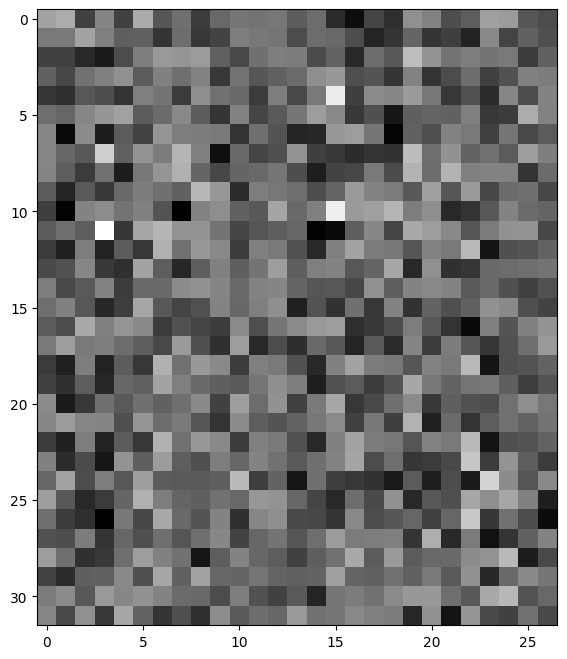

In [ ]:
#showing dlogits
plt.figure(figsize=(8,8))
plt.imshow(logits.detach(), cmap = 'gray')

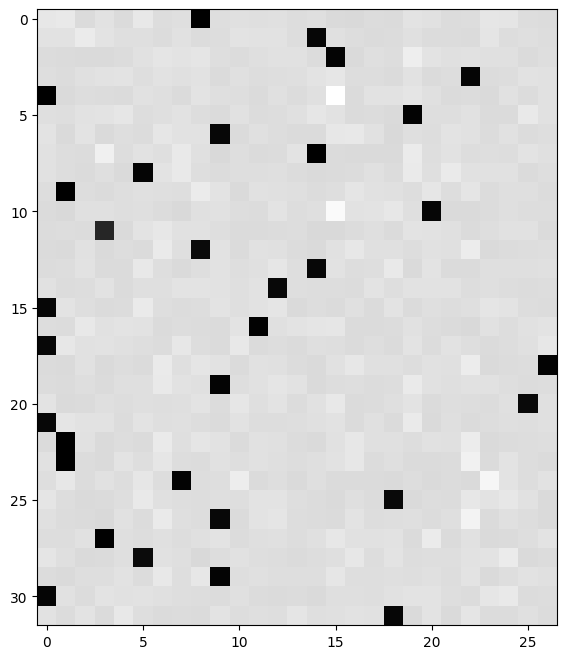

In [ ]:
#showing dlogits
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap = 'gray')

"""Shows cross-entropy gradient changes
Black squares are those correct characters
push up on probabilities of correct characters, pulling up on probabilities of incorrect characters
This plot is representing where the gradient is very low. Black squares.
pushing and pulling on correct and incorrect answers - force is proportional to amount of incorrectness. 
If we are correct, in our predictions no real push/pull is necessary
"""

### Experiment 3 Batch normalization

In [143]:
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0)-n/(n-1) * bnraw*(dhpreact*bnraw).sum(0))

In [144]:
cmp('hbprebn', dhprebn, hprebn)

hbprebn         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
